In [1]:
import datetime
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
import datetime
import os

import huxt as H
import huxt_analysis as HA
import huxt_inputs as Hin

# HUXt examples.

This notebook contains a set of examples of how to use HUXt, as described in Owens et al (2020).

- [Example 1.](#example_1) A 1D HUXt run with user specified boundary conditions.
- [Example 2.](#example_2) A 1D HUXt run with user specified boundary conditions and a cone CME.
- [Example 3.](#example_3) A 2D HUXt run (longitude & radius) with user specified boundary conditions and a cone CME.
- [Example 4.](#example_4) 2D HUXt runs with boundary conditions taken from a range of coronal model and near-Sun observations
- [Example 5.](#example_5) Animating a 2D HUXt run.
- [Example 6.](#example_6) Saving a HUXt run to file and loading results back in.
- [Example 7.](#example_7) Accessing and processing CME tracer particle positions and speeds.
- [Example 8.](#example_8) A 2D HUXt run with boundary conditions taken from HelioMAS and multiple cone CMEs.
- [Example 9.](#example_9) Access ephemeris data for some solar system bodies and the STEREO spacecraft.
- [Example 10.](#example_10) A 2D HUXt run over a limited range of longitudes with multiple cone CMEs.
- [Example 11.](#example_11) Specifying the initial Carrington longitude of Earth at the beginning of a HUXt run.
- [Example 12.](#example_12) Specifying either the synodic or sidereal reference frame for HUXt.
- [Example 13.](#example_13) Computing cone CME arrival time at a solar system body.
- [Example 14.](#example_14) List of model attributes.
- [Example 15.](#example_15) Mapping inner boundary conditions to different heights.
- [Example 16.](#example_16) Tracing flow streaklines.
- [Example 17.](#example_17) Tracing the radial IMF polarity.
- [Example 18.](#example_18) Plotting time series of solar wind speed and IMF polarity at Earth.
- [Example 19.](#example_19) An example of running HUXt in 3D, plotting and animating the solution
- [Example 20.](#example_20) HUXt can be run from 1-AU outwards using OMNI observations.

## Example 1.
<a id="example_1"></a>
Run HUXt in 1D (along one longitude) with user specified V boundary conditions and no CMEs

No initiation time specified. Defaulting to start of CR2000, 20/2/2003


(<Figure size 1008x504 with 1 Axes>,
 <AxesSubplot:title={'center':'HUXt Radius: 214.50$R_{sun}$  Longitude: 0.02$^\\circ$'}, xlabel='Time (days)', ylabel='Solar Wind Speed (km/s)'>)

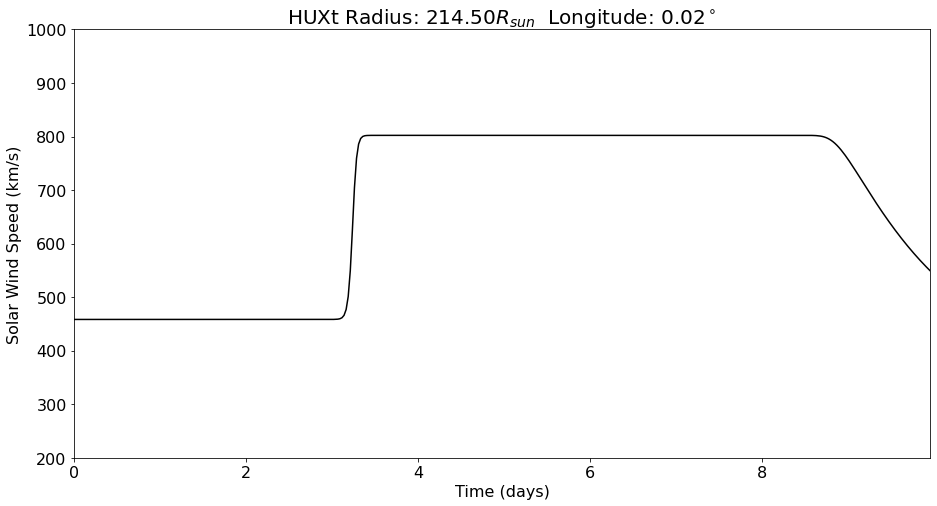

In [2]:
#Form longitudinal boundary conditions - background wind of 400 km/s with two fast streams.
v_boundary = np.ones(128) * 400 * (u.km/u.s)
v_boundary[30:50] = 600 * (u.km/u.s)
v_boundary[95:125] = 700 * (u.km/u.s)

# This boundary condition looks like
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(v_boundary,'k-')
ax.set_xlabel('Longitude bin')
ax.set_ylabel('Input Wind Speed (km/s)')
ax.set_xlim(0,128)

# Setup HUXt to do a 5 day simulation, with model output every 4 timesteps (roughly half and hour time step), looking at 0 longitude
model = H.HUXt(v_boundary=v_boundary, lon_out=0.0*u.deg, simtime=10*u.day, dt_scale=4)

# Solve these conditions, with no ConeCMEs added.
cme_list = []
model.solve(cme_list)

# Plot the radial profile of the ambient wind profile at a fixed time (in days). 
t = 1.5*u.day
HA.plot_radial(model, t, lon=0.0)

# Plot the time series of the ambient wind profile at a fixed radius. 
r = 1.0*u.AU
HA.plot_timeseries(model, r, lon=0.0)

## Example 2.
<a id="example_2"></a>
Run HUXt in 1D (along one longitude) with user specified V boundary conditions and a cone CME.

No initiation time specified. Defaulting to start of CR2000, 20/2/2003


(<Figure size 1008x504 with 1 Axes>,
 <AxesSubplot:title={'center':'HUXt Radius: 214.50$R_{sun}$  Longitude: 0.02$^\\circ$'}, xlabel='Time (days)', ylabel='Solar Wind Speed (km/s)'>)

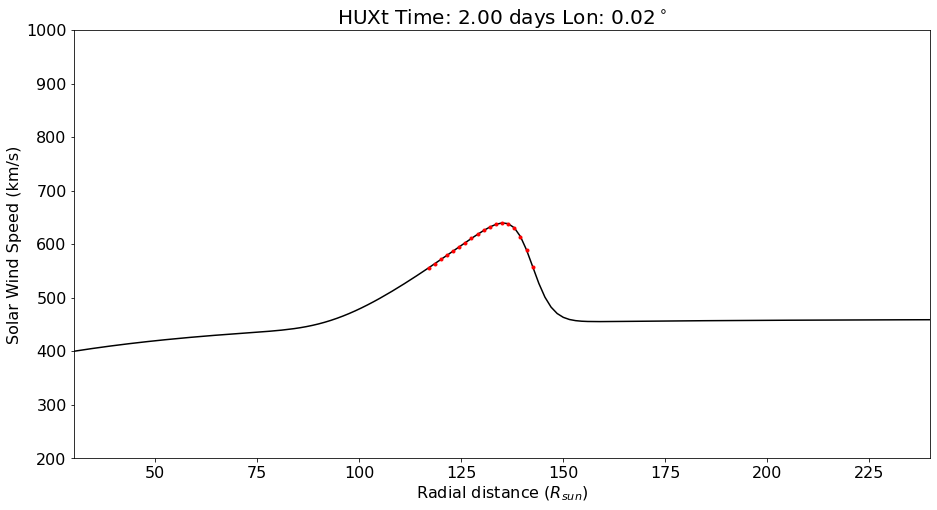

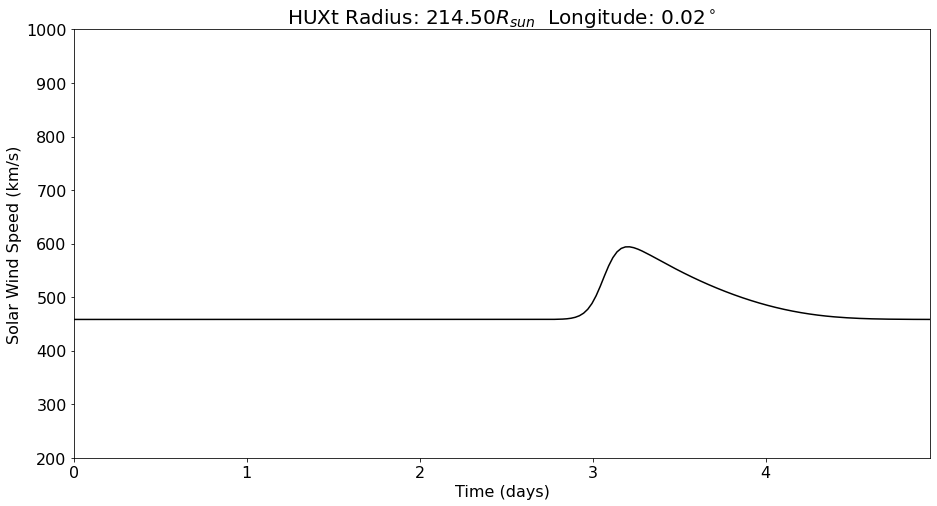

In [3]:
# Set up a ConeCME that launches half a day after the simulation begins, at 0 longitude, 30 degree width, speed 850km/s and thickness=5 solar radii
cme = H.ConeCME(t_launch=0.5*u.day, longitude=0.0*u.deg, width=30*u.deg, v=850*(u.km/u.s), thickness=5*u.solRad)
cme_list = [cme]

# Setup HUXt to do a 5 day simulation, with model output every 4 timesteps (roughly half and hour time step), looking at 0 longitude
#Form longitudinal boundary conditions - background wind of 400 km/s with two fast streams.
v_boundary = np.ones(128) * 400 * (u.km/u.s)
model = H.HUXt(v_boundary=v_boundary, lon_out=0.0*u.deg, simtime=5*u.day, dt_scale=4)

# Run the model, and this time save the results to file.
model.solve(cme_list, save=True, tag='1d_conecme_test')

# Plot the radial profile and time series of both the ambient and ConeCME solutions at a fixed time (in days). 
# Save both to file as well. These are saved in HUXt>figures>HUXt1D
t = 2*u.day
HA.plot_radial(model, t, lon=0.0*u.deg, save=True)

r = 1.0*u.AU
HA.plot_timeseries(model, r, lon=0.0*u.deg, tag='1d_cone_test_radial')

## Example 3.
<a id="example_3"></a>
HUXt can also be run over multiple longitudes to provide a 2D solution. 

Here HUXt is run over all longitudes, with user specified boundary conditions and a single CME

No initiation time specified. Defaulting to start of CR2000, 20/2/2003


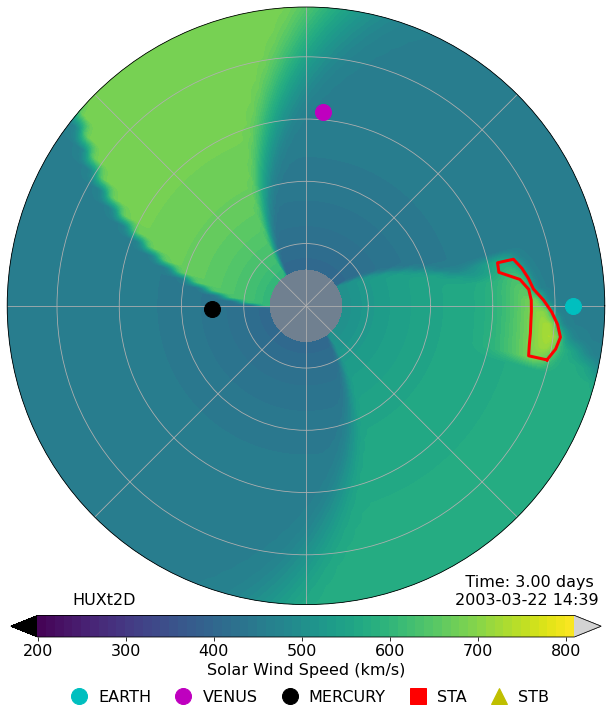

In [5]:
#  Form boundary conditions - background wind of 400 km/s with two fast streams.
v_boundary = np.ones(128) * 400 * (u.km/u.s)
v_boundary[30:50] = 600 * (u.km/u.s)
v_boundary[95:125] = 500 * (u.km/u.s)

#  Add a CME
cme = H.ConeCME(t_launch=1*u.day, longitude=360*u.deg, latitude = 0*u.deg, width=30*u.deg, v=1000*(u.km/u.s), thickness=5*u.solRad)
cme_list = [cme]

#  Setup HUXt to do a 5 day simulation, with model output every 4 timesteps (roughly half and hour time step)
model = H.HUXt(v_boundary=v_boundary, latitude = 0*u.deg, simtime=6*u.day, dt_scale=4)

model.solve(cme_list, tag='cone_cme_test')

# Plot this out
t_interest = 3*u.day
fig, ax = HA.plot(model, t_interest)

## Example 4.
<a id="example_4"></a>

HUXt can be run with solar wind speed output from any coronal model or near-Sun observations. For convenience, there are functions for obtaining on demand boundary conditions from the Predictive Science Inc. MHDweb archive of MAS and HelioMAS runs (https://www.predsci.com/mhdweb/home.php).

Files already exist for CR2254


Text(0.5, 0.98, 'MAS/HUXt')

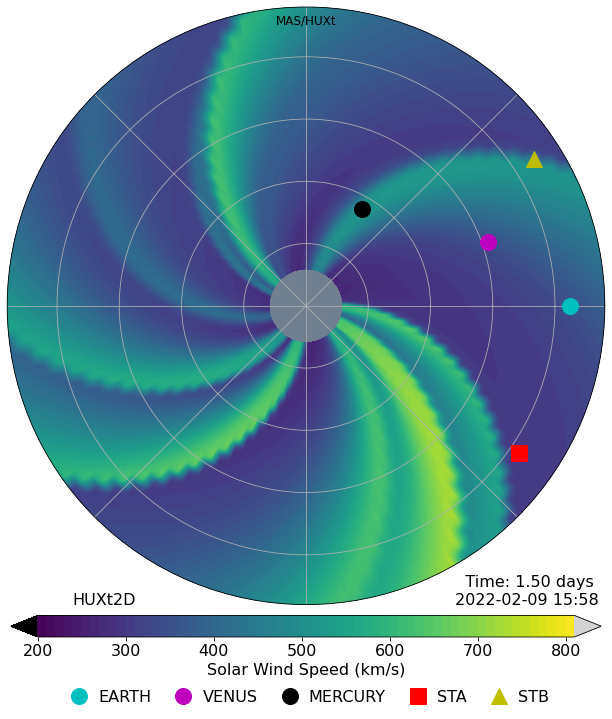

In [2]:
#HUXt can be easily initiated MAS, by specifying a carrington rotation number. Data are downloaded from the Pred Sci Inc archive on demand
cr = 2254
v_mas = Hin.get_MAS_long_profile(cr, 0.0*u.deg)

#MAS solutions are at 30 rS
model = H.HUXt(v_boundary=v_mas, cr_num=cr, simtime=5*u.day, dt_scale=4, r_min = 30*u.solRad)
model.solve([])

# Plot the solution 
fig, ax = HA.plot(model, 1.5*u.day)
fig.suptitle('MAS/HUXt')

Example PFSS, WSA and CorTom output is provided in data/example_input. Data readers as provided as part of huxt_inputs. 

Text(0.5, 0.98, 'CorTom/HUXt')

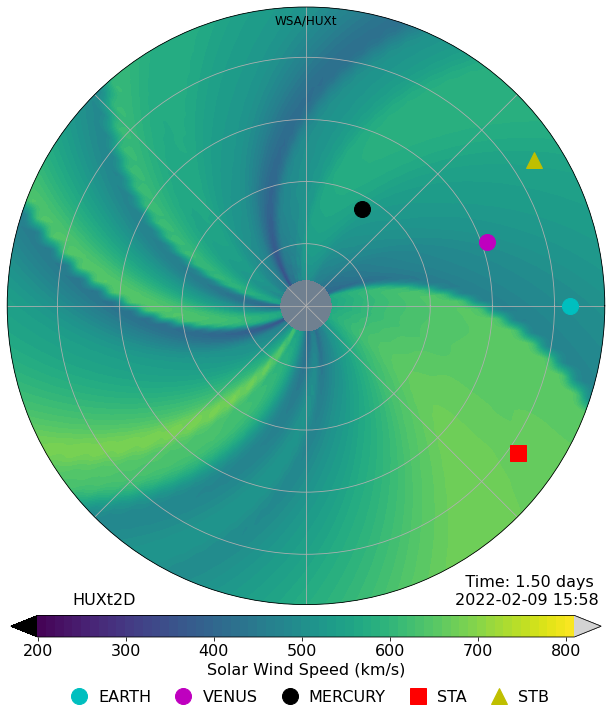

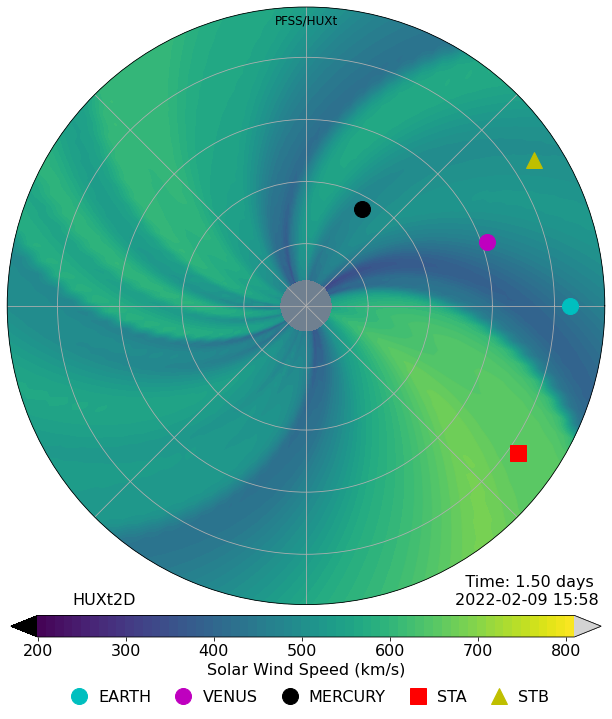

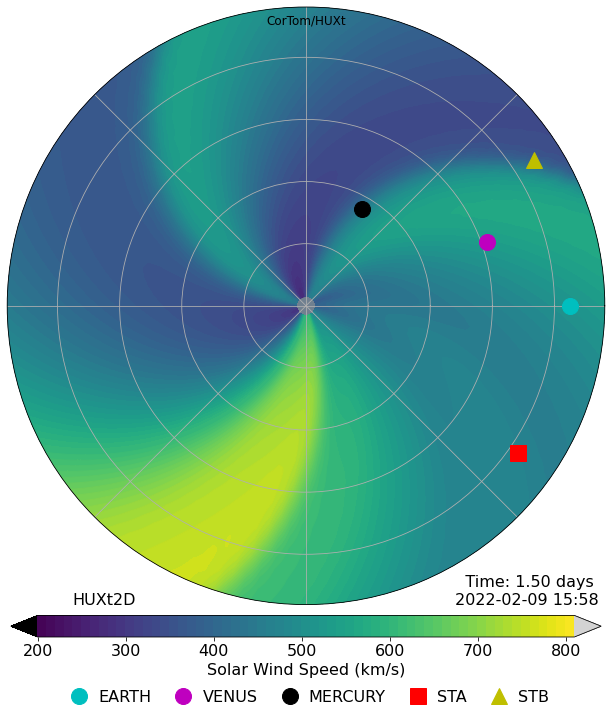

In [3]:
# read in the data
cr = 2254

demo_dir = H._setup_dirs_()['example_inputs']
wsafilepath = os.path.join(demo_dir, '2022-02-24T22Z.wsa.gong.fits')
pfssfilepath = os.path.join(demo_dir, 'windbound_b_pfss20220224.22.nc')
cortomfilepath = os.path.join(demo_dir, 'tomo_8.00_20220224_tomo.txt')

v_wsa = Hin.get_WSA_long_profile(wsafilepath, lat=0.0 * u.deg)
v_pfss = Hin.get_PFSS_long_profile(pfssfilepath, lat=0.0 * u.deg)
v_cortom = Hin.get_CorTom_long_profile(cortomfilepath, lat=0.0 * u.deg)

# set up and run the models. WSA and PFSS maps are at 21.5 rS, CorTom at 8 rS
model = H.HUXt(v_boundary=v_wsa, cr_num=cr, simtime=5*u.day, dt_scale=4, r_min = 21.5*u.solRad)
model.solve([])
fig, ax = HA.plot(model, 1.5*u.day)
fig.suptitle('WSA/HUXt')

model = H.HUXt(v_boundary=v_pfss, cr_num=cr, simtime=5*u.day, dt_scale=4, r_min = 21.5*u.solRad)
model.solve([])
fig, ax = HA.plot(model, 1.5*u.day)
fig.suptitle('PFSS/HUXt')

model = H.HUXt(v_boundary=v_cortom, cr_num=cr, simtime=27*u.day, dt_scale=4, r_min = 8*u.solRad)
model.solve([])
fig, ax = HA.plot(model, 1.5*u.day)
fig.suptitle('CorTom/HUXt')


## Example 5.
<a id="example_5"></a>
There is also a function to animate HUXt output. Movies are saved in HUXt>Figures as .mpg4

In [6]:
#set up and run previous example of idealised solar wind with single CME
#=======================================================================
v_boundary = np.ones(128) * 400 * (u.km/u.s)
v_boundary[30:50] = 600 * (u.km/u.s)
v_boundary[95:125] = 500 * (u.km/u.s)

#  Add a CME
cme = H.ConeCME(t_launch=1*u.day, longitude=360*u.deg, latitude = 0*u.deg, width=30*u.deg, v=1000*(u.km/u.s), thickness=5*u.solRad)

#  Setup HUXt to do a 5 day simulation, with model output every 4 timesteps (roughly half and hour time step)
model = H.HUXt(v_boundary=v_boundary, latitude = 0*u.deg, simtime=6*u.day, dt_scale=4)
model.solve([cme], tag='cone_cme_test')

#create the animation
#==========================
HA.animate(model, tag='cone_cme_test') # This takes about two minutes.

Moviepy - Building video C:\Users\yq904481\research\repos\HUXt\figures\HUXt_CR2000_cone_cme_test_movie.mp4.
Moviepy - Writing video C:\Users\yq904481\research\repos\HUXt\figures\HUXt_CR2000_cone_cme_test_movie.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\yq904481\research\repos\HUXt\figures\HUXt_CR2000_cone_cme_test_movie.mp4


## Example 6.
<a id="example_6"></a>
HUXt results can be saved to a HDF5 file, either automatically in the solve method, or by a separate save method. There is also a load function. 

No initiation time specified. Defaulting to start of CR2000, 20/2/2003


(<Figure size 720x720 with 2 Axes>, <PolarAxesSubplot:>)

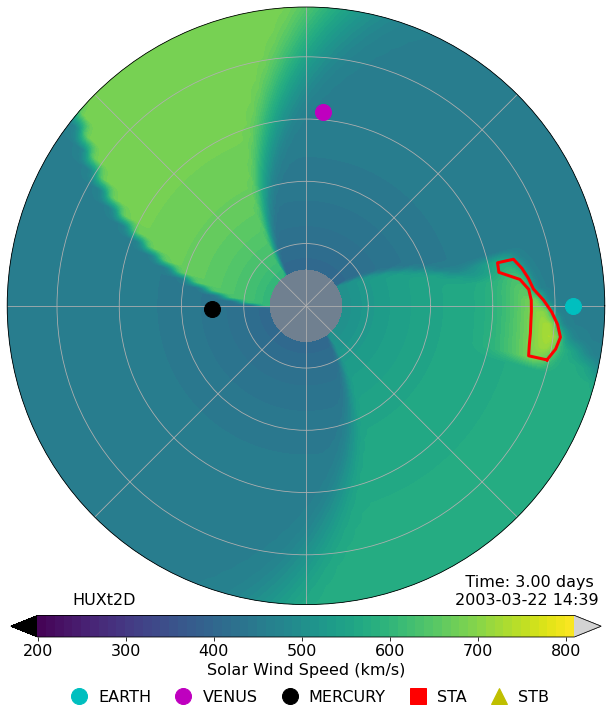

In [4]:
#set up and run previous example of idealised solar wind with single CME
#=======================================================================
v_boundary = np.ones(128) * 400 * (u.km/u.s)
v_boundary[30:50] = 600 * (u.km/u.s)
v_boundary[95:125] = 500 * (u.km/u.s)

#  Add a CME
cme = H.ConeCME(t_launch=1*u.day, longitude=360*u.deg, latitude = 0*u.deg, width=30*u.deg, v=1000*(u.km/u.s), thickness=5*u.solRad)

#  Setup HUXt to do a 5 day simulation, with model output every 4 timesteps (roughly half and hour time step)
model = H.HUXt(v_boundary=v_boundary, latitude = 0*u.deg, simtime=6*u.day, dt_scale=4)
model.solve([cme], tag='cone_cme_test')

#save the data
#==========================
out_path = model.save(tag='cone_cme_test')

# And load it back in with
model2, cme_list2 = H.load_HUXt_run(out_path)

#plot it
HA.plot(model2, 3*u.day)

## Example 7.
<a id="example_7"></a>
CMEs are tracked through the HUXt domain using test particles that advect with the flow. These coordinates are accessible via the ConeCME objects.

No initiation time specified. Defaulting to start of CR2000, 20/2/2003


Text(0, 0.5, 'Y ($R_{sun}$)')

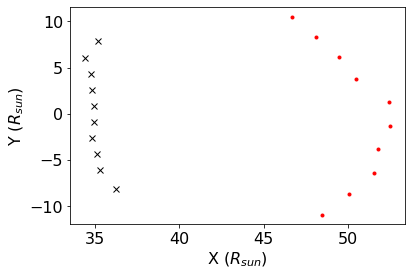

In [6]:
#set up and run previous example of idealised solar wind with single CME
#=======================================================================
v_boundary = np.ones(128) * 400 * (u.km/u.s)
v_boundary[30:50] = 600 * (u.km/u.s)
v_boundary[95:125] = 500 * (u.km/u.s)

#  Add a CME
cme = H.ConeCME(t_launch=1*u.day, longitude=360*u.deg, latitude = 0*u.deg, width=30*u.deg, v=1000*(u.km/u.s), thickness=5*u.solRad)

#  Setup HUXt to do a 5 day simulation, with model output every 4 timesteps (roughly half and hour time step)
model = H.HUXt(v_boundary=v_boundary, latitude = 0*u.deg, simtime=5*u.day, dt_scale=4)
model.solve([cme], tag='cone_cme_test')

#extract the CME position and convert to cartesian for plotting
#============================================================
cme = model.cmes[0]
timestep = 50
r = cme.coords[timestep]['r'].to(u.solRad)
lon = cme.coords[timestep]['lon']
x = r * np.cos(lon)
y = r * np.sin(lon)

# There is also a "front_id" field to separate the nose and rear.
id_front = cme.coords[timestep]['front_id'] == 1.0
id_back = cme.coords[timestep]['front_id'] == 0.0

#plot it
fig, ax = plt.subplots() # compare this with the boundary in the frame above.
ax.plot(x[id_front] , y[id_front] , 'r.')
ax.plot(x[id_back] , y[id_back] , 'kx')
ax.set_xlabel('X ($R_{sun}$)')
ax.set_ylabel('Y ($R_{sun}$)')

The flow speed is also tracked by the CME particles, and is also accessible as a CME coordinate as follows.

Text(0, 0.5, 'V ($km/s$)')

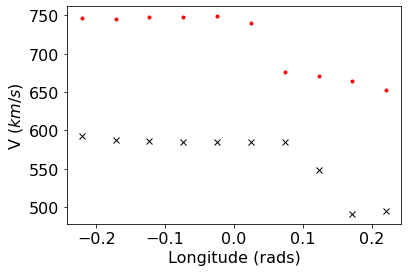

In [7]:
cme = model.cmes[0]
timestep = 50
v = cme.coords[timestep]['v']
lon = cme.coords[timestep]['lon']

# There is also a "front_id" field to separate the nose and rear.
id_front = cme.coords[timestep]['front_id'] == 1.0
id_back = cme.coords[timestep]['front_id'] == 0.0

fig, ax = plt.subplots() # compare this with the boundary in the frame above.
ax.plot(lon[id_front] , v[id_front] , 'r.')
ax.plot(lon[id_back] , v[id_back] , 'kx')
ax.set_xlabel('Longitude (rads)')
ax.set_ylabel('V ($km/s$)')

## Example 8.
<a id="example_8"></a>
Multiple Cone CMEs can be inserted into HUXt in any run. Also, functions are provided to download inner boundary conditions from the HelioMAS model. Below we set up HUXt to run for Carrington rotation 2100, retrieving the boundary condition from Predictive Science (unless it is already downloaded). Then three Cone CMEs are inserted, and the output animated.

Files already exist for CR2100


(<Figure size 720x720 with 2 Axes>, <PolarAxesSubplot:>)

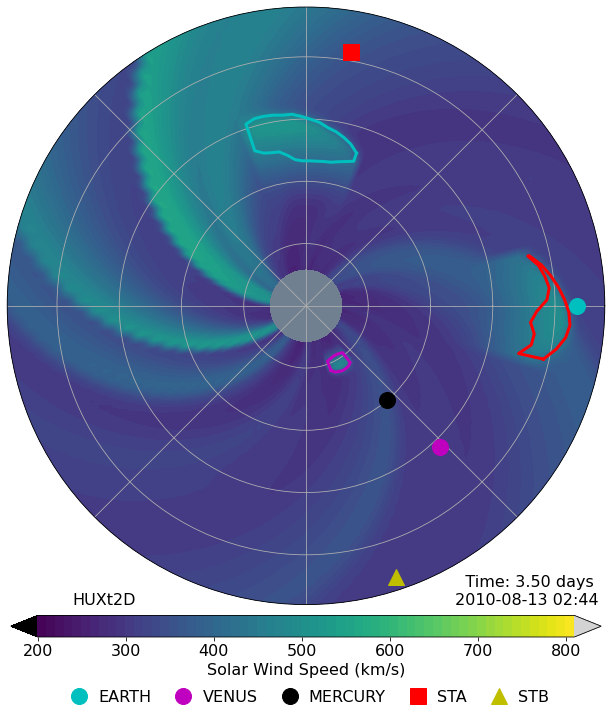

In [10]:
#  Get inner boundary condition from Carrington rotation 2100
cr=2100
vr_in = Hin.get_MAS_long_profile(cr, 0.0*u.deg)
#  Setup HUXt to do a 5 day simulation, with model output every 4 timesteps (roughly half and hour time step).
model = H.HUXt(v_boundary=vr_in, cr_num=cr, simtime=5*u.day, dt_scale=4)

# Produce a list of ConeCMEs to pass to HUXt
daysec = 86400
times = [0.5*daysec, 1.5*daysec, 3*daysec]
speeds = [850, 1000, 700]
lons = [0, 90, 300]
widths = [30, 40, 20]
thickness = [5, 4, 2]
cme_list = []
for t, l, w, v, thick in zip(times, lons, widths, speeds, thickness):
    cme = H.ConeCME(t_launch=t*u.s, longitude=l*u.deg, width=w*u.deg, v=v*model.kms, thickness=thick*u.solRad)
    cme_list.append(cme)

model.solve(cme_list, save=True, tag='multi_cones') 
HA.plot(model, 3.5*u.day)

## Example 9.
<a id="example_9"></a>
There is also an ephemeris of the HEEQ, HAE, and Carrington coordiates of Earth, Mercury, Venus, STEREO-A and STEREO-B

Files already exist for CR2100


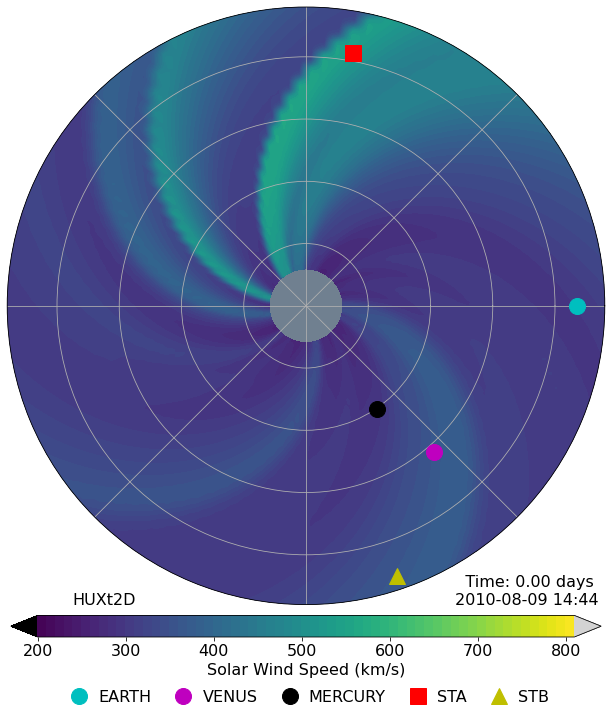

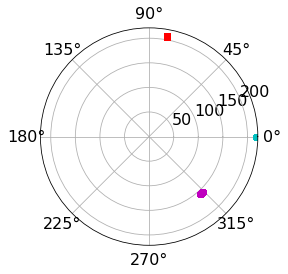

In [8]:
cr=2100
vr_in = Hin.get_MAS_long_profile(cr, 0.0*u.deg)
model = H.HUXt(v_boundary=vr_in, cr_num=cr, simtime=5*u.day, dt_scale=4)
model.solve([])

# These are automatically plotted on model solutions derived from a particular Carrington rotation.
HA.plot(model, model.time_out[0])

# You can retrieve a bodies position at each model timestep like:
earth = model.get_observer('earth')
sta = model.get_observer('sta')
venus = model.get_observer('venus')

# The bodies HEEQ and Carrington coordinates are attributes.
# So to plot them:
fig, ax = plt.subplots(subplot_kw={"projection": "polar"})
ax.plot(earth.lon, earth.r, 'co')
ax.plot(sta.lon, sta.r, 'rs')
ax.plot(venus.lon, venus.r, 'mo')

## Example 10.
<a id="example_10"></a>
HUXt can also be run over a limited range of longitudes. As HUXt is a purely radial model, it can be run over any set of longitudes. This could save disk-space and runtime if you are interested in large ensembles. This is done with the `lon_start` and `lon_stop` arguments.


Files already exist for CR2120


(<Figure size 720x720 with 2 Axes>, <PolarAxesSubplot:>)

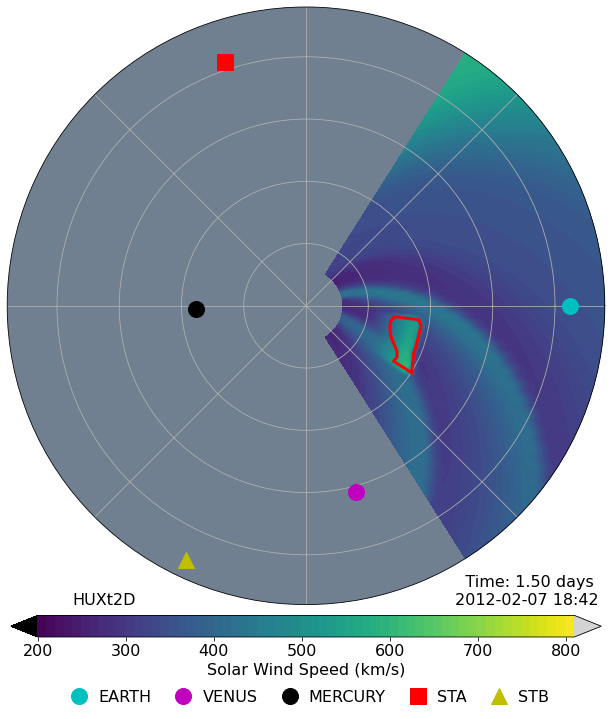

In [12]:
# Set up HUXt over a limited longitude range.
cr=2120
vr_in = Hin.get_MAS_long_profile(cr,0.0*u.deg)
model = H.HUXt(v_boundary=vr_in, cr_num=cr, lon_start=300*u.deg, lon_stop=60*u.deg, simtime=5*u.day, dt_scale=4)

# Get a list of two ConeCMEs
daysec = 86400
times = [0.5*daysec, 2*daysec]
speeds = [1000, 850]
lons = [-20, 20]
widths = [30, 30]
thickness = [8, 4]
cme_list = []
for t, l, w, v, thick in zip(times, lons, widths, speeds, thickness):
    cme = H.ConeCME(t_launch=t*u.s, longitude=l*u.deg, width=w*u.deg, v=v*model.kms, thickness=thick*u.solRad)
    cme_list.append(cme)

model.solve(cme_list, save=True, tag='multi_cones') 

t_interest = 1.5*u.day
HA.plot(model, t_interest)

## Example 11.
<a id="example_11"></a>
The initial carrington longitude of Earth can be specified with the `cr_lon_init` argument. This sets the `time_init` attribute, so model times can be converted to UTC.

Files already exist for CR2120
360.0 deg 2012-02-06T06:42:33.508
270.0 deg 2012-02-13T02:45:10.629
180.0 deg 2012-02-19T22:47:12.384


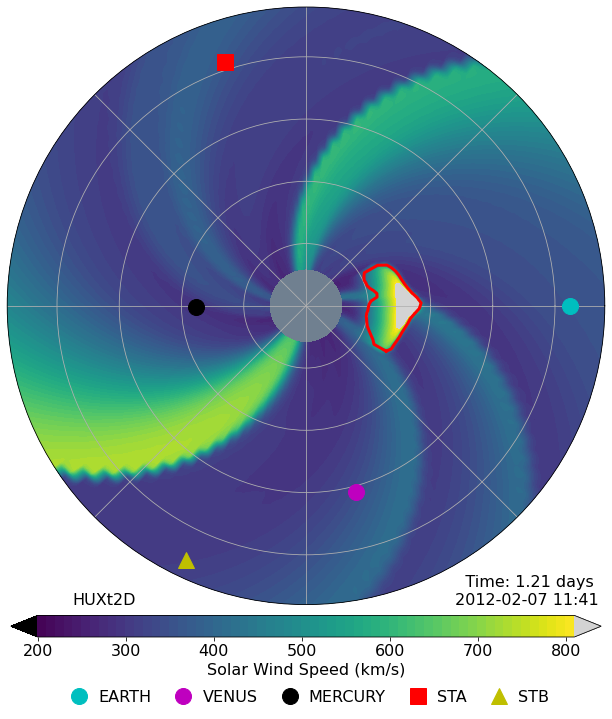

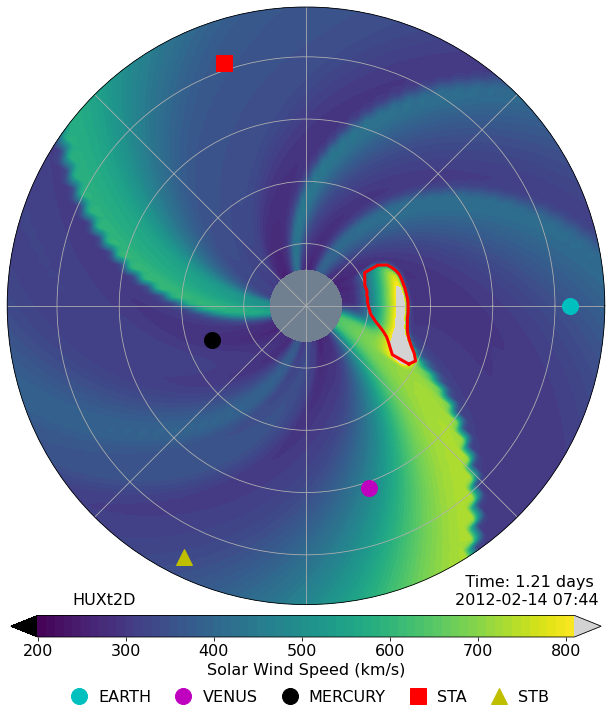

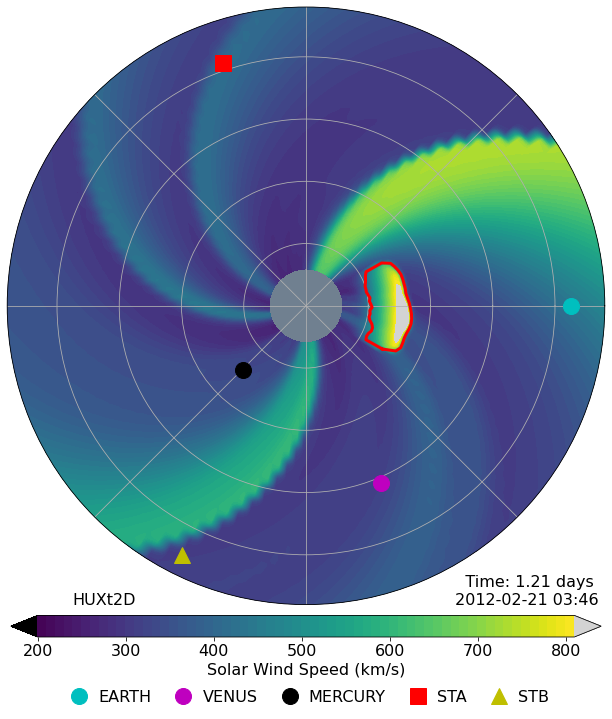

In [13]:
cr=2120
vr_in = Hin.get_MAS_long_profile(cr,0.0*u.deg)

for cr_lon in [360, 270, 180]:
    model = H.HUXt(v_boundary=vr_in, cr_num=cr, cr_lon_init=cr_lon*u.deg, simtime=5*u.day, dt_scale=4)
    cme = H.ConeCME(t_launch=0.5*u.day, longitude=0.0*u.deg, width=60*u.deg, v=1000*(u.km/u.s), thickness=5*u.solRad)
    model.solve([cme])
    cr_tag = 'cr_lon_{:03d}'.format(np.int32(cr_lon))
    HA.plot(model, model.time_out[50], save=True, tag=cr_tag)
    print(model.cr_lon_init.to('deg'), model.time_init.isot)


## Example 12.
<a id="example_12"></a>
HUXt can be run with two rerfernce frames - the inner boundary is rotated with either the mean sidreal rotation rate, or with the synodic rotation rate from Earth's perspective. This is set with the `frame` argument. This doesn't always have a large effect on the solution, but can be worth considering. For example, in highly structured solar wind it can affect the CME arrival time by a few hours. 

Files already exist for CR2120
Adjusting CME HEEQ longitude for sidereal frame


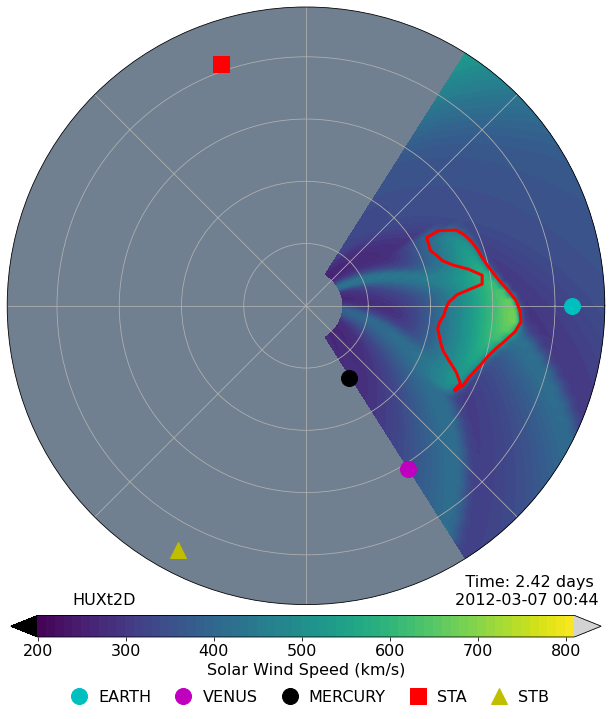

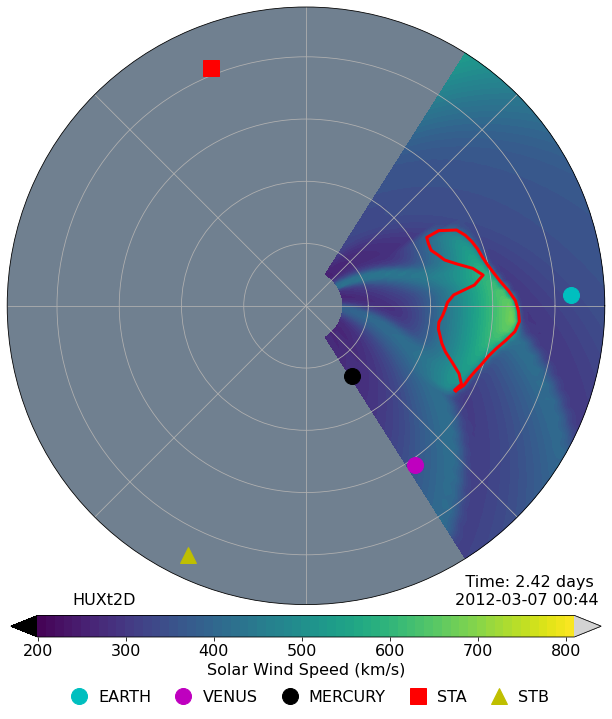

In [8]:
cr=2120
vr_in = Hin.get_MAS_long_profile(cr,0.0*u.deg)

# Synodic
model = H.HUXt(v_boundary=vr_in, cr_num=cr, cr_lon_init=0*u.deg, simtime=5*u.day, dt_scale=4, lon_start=300*u.deg, lon_stop=60*u.deg, frame='synodic')
cme = H.ConeCME(t_launch=0.5*u.day, longitude=0.0*u.deg, width=60*u.deg, v=1000*(u.km/u.s), thickness=5*u.solRad)
model.solve([cme])
fig, ax = HA.plot(model, model.time_out[100], save=True, tag='synodic')

# Sidereal
model = H.HUXt(v_boundary=vr_in, cr_num=cr, cr_lon_init=0*u.deg, simtime=5*u.day, dt_scale=4, lon_start=300*u.deg, lon_stop=60*u.deg, frame='sidereal')
cme = H.ConeCME(t_launch=0.5*u.day, longitude=0.0*u.deg, width=60*u.deg, v=1000*(u.km/u.s), thickness=5*u.solRad)
model.solve([cme])
fig, ax = HA.plot(model, model.time_out[100], save=True, tag='sidereal')

## Example 13.
<a id="example_13"></a>
A function is included to compute the arrival time of CMEs at the solar system bodies available in the Observer class - Mercury, Venus, Earth, STEREO-A and STEREO-B. We will use this to show how the different synodic and sidereal frames can affect the CMEs arrival time. In this instance the CME is strongly affected by a high speed stream, and the CME arrival time at Earth is about 4 hours different for the synodic and sidereal frames. 

Files already exist for CR2056
Adjusting CME HEEQ longitude for sidereal frame
**************************************
sidereal: Earth arrival:2007-05-27T12:03:59.946,  Transit time:2.04 d days, Arrival longitude:0.04 rad, Speed:727.32 km / s
**************************************
synodic: Earth arrival:2007-05-27T15:57:35.662,  Transit time:2.21 d days, Arrival longitude:0.00 rad, Speed:670.86 km / s


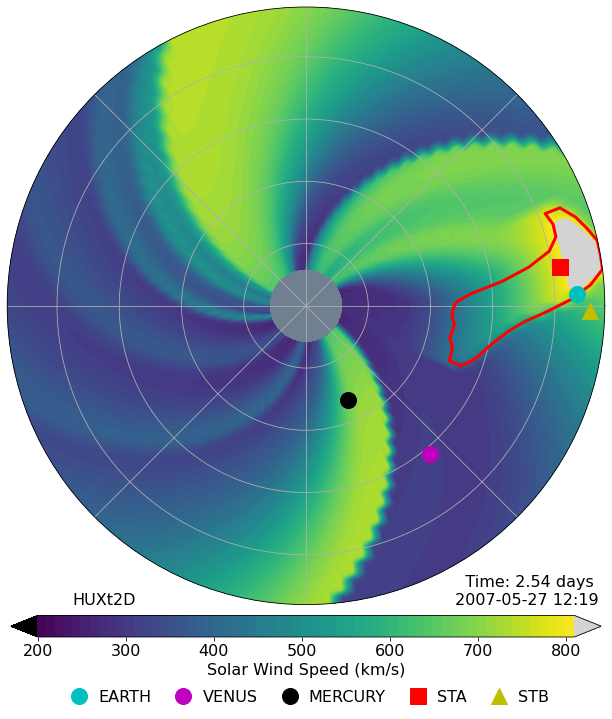

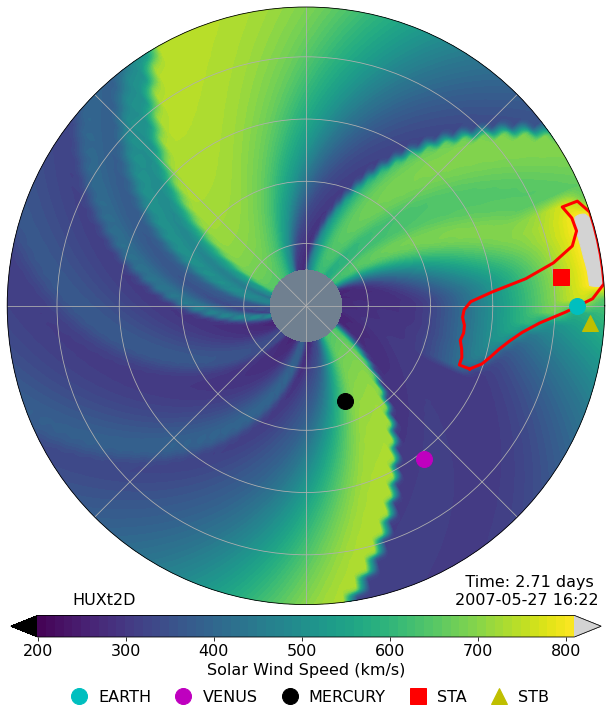

In [15]:
cr=2056
vr_in = Hin.get_MAS_long_profile(cr, 0.0*u.deg)

#  Synodic
for frame in ['sidereal', 'synodic']:
    model = H.HUXt(v_boundary=vr_in, cr_num=cr, cr_lon_init=0*u.deg, simtime=5*u.day, dt_scale=4, frame=frame)
    cme = H.ConeCME(t_launch=0.5*u.day, longitude=0.0*u.deg, width=45*u.deg, v=1000*(u.km/u.s), thickness=5*u.solRad)
    model.solve([cme])
    cme = model.cmes[0]
    stats = cme.compute_arrival_at_body('EARTH')
    
    #  Plot the solution at the nearest time step to impact.
    HA.plot(model, model.time_out[stats['hit_id']])
    
    #  Print out some arrival stats
    print("**************************************")
    output_text = "{}: Earth arrival:{},  Transit time:{:3.2f} days, Arrival longitude:{:3.2f}, Speed:{:3.2f}" 
    print(output_text.format(frame, stats['t_arrive'].isot, stats['t_transit'], stats['lon'], stats['v']))


## Example 14.
<a id="example_14"></a>
Most of the model parameters are attributes of the HUXt class and so can be accessed like:

In [10]:
cr=2120
vr_in = Hin.get_MAS_long_profile(cr,0.0*u.deg)
model = H.HUXt(v_boundary=vr_in, cr_num=cr, cr_lon_init=0*u.deg, simtime=5*u.day, dt_scale=4, frame='synodic')
cme = H.ConeCME(t_launch=0.5*u.day, longitude=0.0*u.deg, width=60*u.deg, v=1000*(u.km/u.s), thickness=5*u.solRad)
model.solve([cme])

# Model time step from the CFL condition:
print('Model time step is: ', model.dt)
# Output model time step
print('Data output time step is', model.dt_out)
# A list of all attributes is in the documentation
help(model)

Files already exist for CR2120
Model time step is:  521.775 s
Data output time step is 2087.1 s
Help on HUXt in module huxt object:

class HUXt(builtins.object)
 |  HUXt(v_boundary=<Quantity nan km / s>, cr_num=nan, cr_lon_init=<Quantity 360. deg>, latitude=<Quantity 0. deg>, r_min=<Quantity 30. solRad>, r_max=<Quantity 240. solRad>, lon_out=<Quantity nan rad>, lon_start=<Quantity nan rad>, lon_stop=<Quantity nan rad>, simtime=<Quantity 5. d>, dt_scale=1.0, frame='synodic', input_v_ts=<Quantity nan km / s>, input_iscme_ts=nan, input_t_ts=<Quantity nan s>, enable_field_tracer=False, track_cmes=True)
 |  
 |  A class containing the HUXt model described in Owens et al. (2020, DOI: 10.1007/s11207-020-01605-3)
 |  
 |  Users must specify the solar wind speed boundary condition through the v_boundary keyword
 |  argument. Failure to do so defaults to a 400 km/s boundary.
 |  
 |  Model coordinate system is HEEQ radius and longitude.
 |  
 |  Attributes:
 |      cmes: A list of ConeCME instan

## Example 15.
<a id="example_15"></a>
The inner boundary of HUXt defaults to 30Rs. But it can be specified by the user. To use the HelioMAS solutions with lower inner boundary heights, a function is provided to give an approximate mapping between the 30Rs solution and a lower specified height. Below, the 30Rs solution is mapped to 21.5Rs, the standard for Enlil, etc.

WARNING: It is not advisable to map solutions beyond around 5-10 rS, as the acceleration equation may not be valid. Also note that as results need to be interpolated onto a regular grid, mapped and unmapped solutions will not be identical.

Files already exist for CR2054


(<Figure size 1008x504 with 1 Axes>,
 <AxesSubplot:title={'center':'HUXt Radius: 215.50$R_{sun}$  Longitude: 0.02$^\\circ$'}, xlabel='Time (days)', ylabel='Solar Wind Speed (km/s)'>)

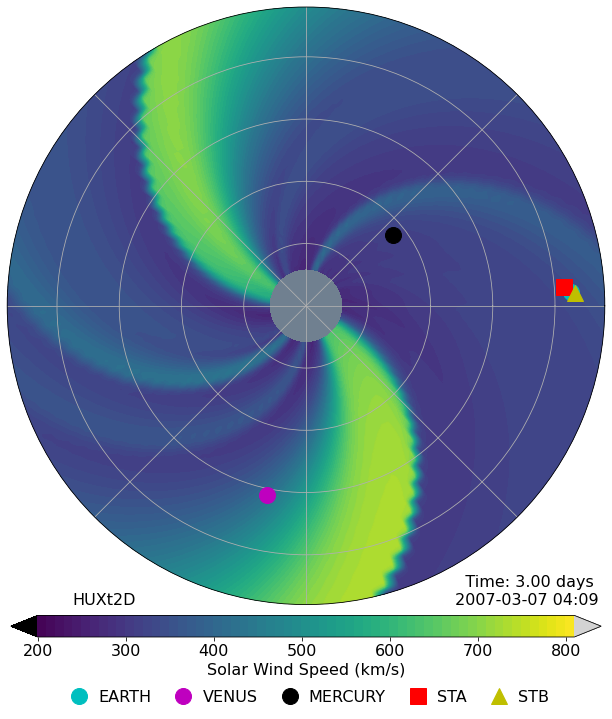

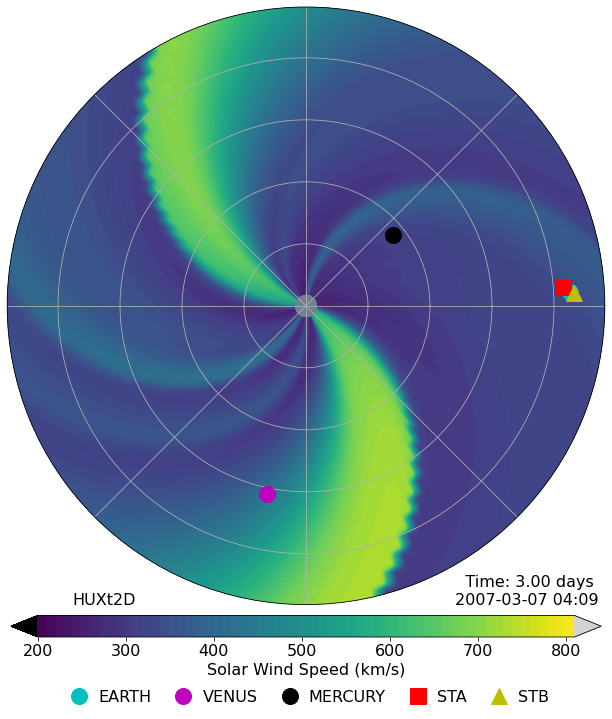

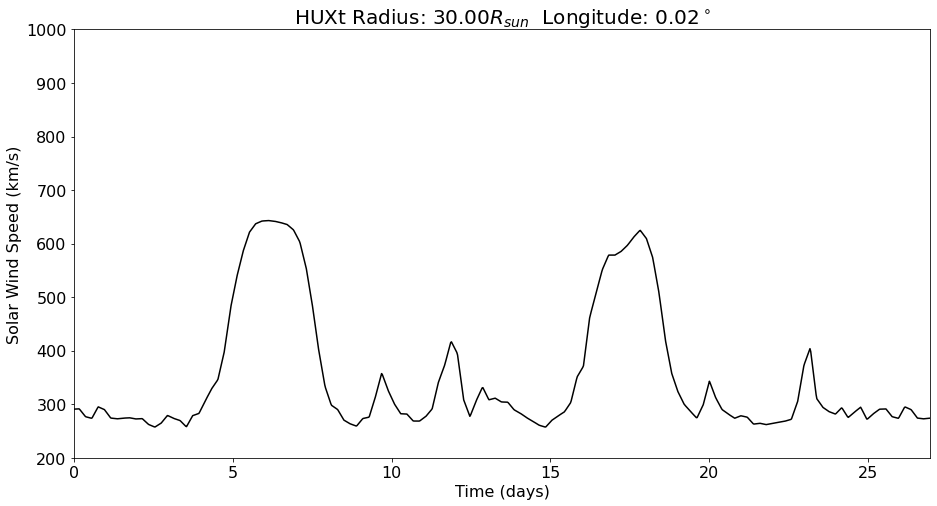

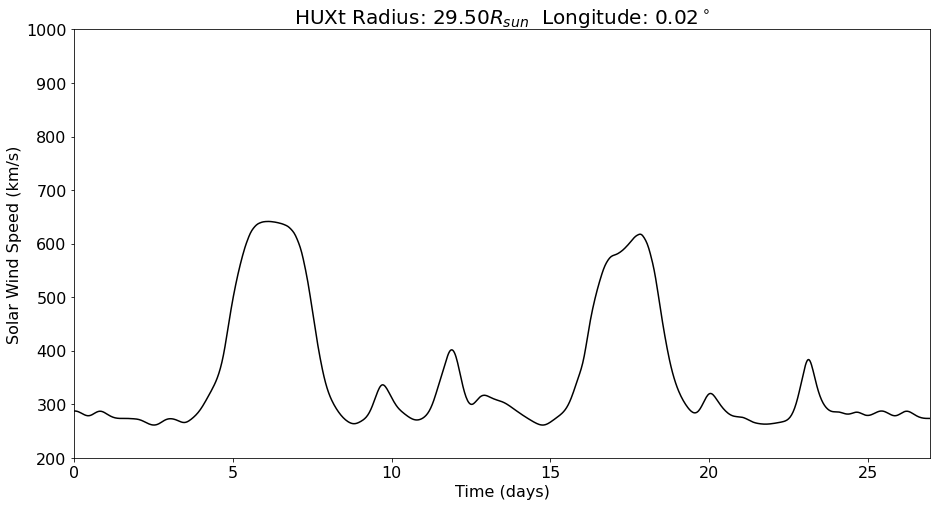

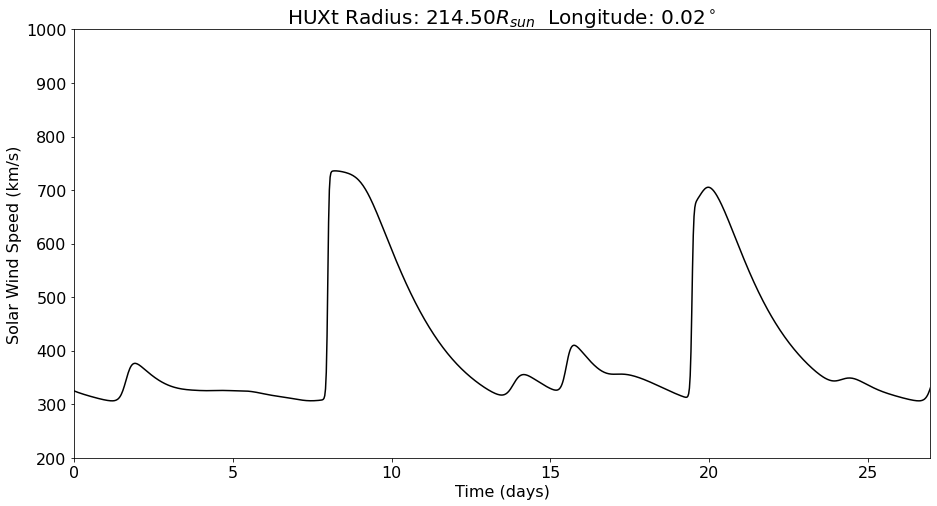

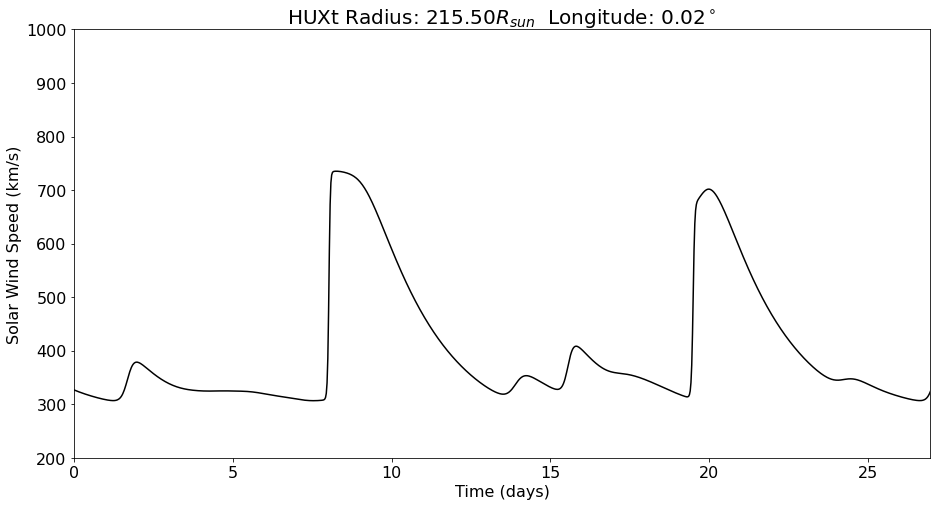

In [2]:
# Setup HUXt for a standard 30Rs run
cr = 2054
vr_in = Hin.get_MAS_long_profile(cr,0.0*u.deg)
#now run HUXt
model30 = H.HUXt(v_boundary=vr_in, cr_num=cr, latitude=0*u.deg, simtime=27*u.day, dt_scale=4, frame = 'sidereal')
model30.solve([]) 

#  Map the inner boundary MAS values inwards from 30 rS to 10 rS
vr_10rs = Hin.map_v_boundary_inwards(vr_in, 30*u.solRad, 10*u.solRad)

#  Now setup HUXt to run from 10Rs
model10 = H.HUXt(v_boundary = vr_10rs, cr_num=cr, simtime=27*u.day, 
               latitude=0*u.deg, dt_scale=4, r_min=10*u.solRad, frame = 'sidereal')
model10.solve([])

#plot the 30 and 21.5 rS solutions. (They should be the same, though not numerically identical)
t_interest=3*u.day
HA.plot(model30, t_interest)
HA.plot(model10, t_interest)

r = 30*u.solRad
HA.plot_timeseries(model30, r, lon=0*u.deg)
HA.plot_timeseries(model10, r, lon=0*u.deg)

r = 215*u.solRad
HA.plot_timeseries(model30, r, lon=0*u.deg)
HA.plot_timeseries(model10, r, lon=0*u.deg)

## Example 16.
<a id="example_16"></a>
HUXt has post-processing support for tracing streaklines (equivalent to passive magnetic flux tubes) through a given velocity field

Files already exist for CR2254
Adjusting CME HEEQ longitude for sidereal frame


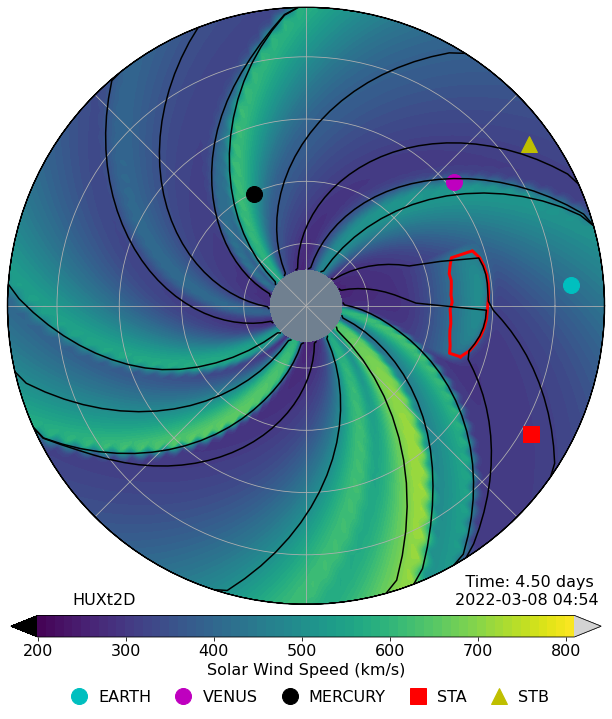

In [3]:
#to trace streaklines/fields, save every HUXt time step (including spin up), using the "enable_field_tracer" flag
cr = 2254
vr_in = Hin.get_MAS_long_profile(cr, 0.0*u.deg)
model = H.HUXt(v_boundary=vr_in, cr_num=cr, cr_lon_init = 50*u.deg, simtime=5*u.day, dt_scale=1, frame='sidereal',  enable_field_tracer = True)
#add a CME and solve
cme = H.ConeCME(t_launch=2.5*u.day, longitude=0.0*u.deg, width=40*u.deg, v=1000*(u.km/u.s), thickness=5*u.solRad)
cme_list = [cme]
model.solve(cme_list)


#trace a bunch of field lines from a range of evenly spaced Carrington longitudes
dlon = (20*u.deg).to(u.rad).value
lon_grid = np.arange(dlon/2, 2*np.pi-dlon/2 + 0.0001, dlon)*u.rad
Nlon = len(lon_grid)

streak_lines = []   
for i in range(0, Nlon):
    r, l = HA.huxt_streakline(model, lon_grid[i])
    streak_lines.append((r,l))

#plot these streaklines
time = 4.5*u.day
fig, ax = HA.plot(model,time, streaklines = streak_lines, save = 'True', tag = 'CR2254_streaklines')

## Example 17.
<a id="example_17"></a>
The HCS position can be tracked as a streakline and the associated B_polarity grid computed

Files already exist for CR2254
Adjusting CME HEEQ longitude for sidereal frame
Files already exist for CR2254


(<Figure size 720x720 with 2 Axes>, <PolarAxesSubplot:>)

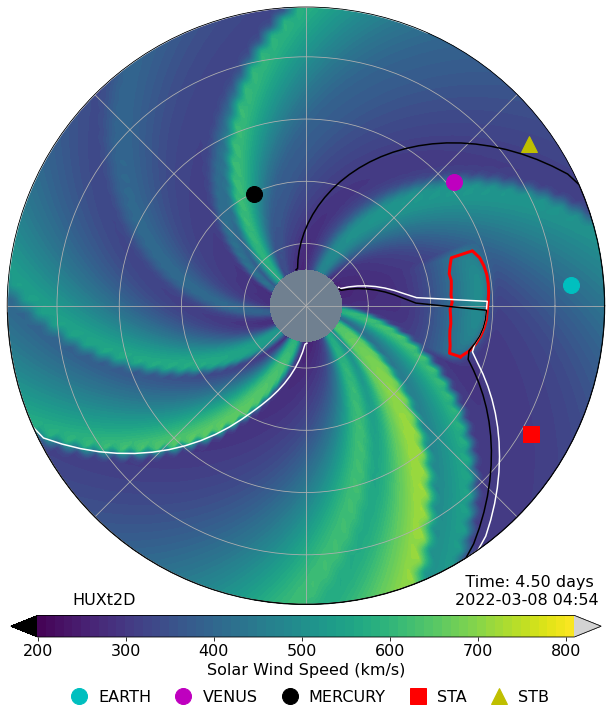

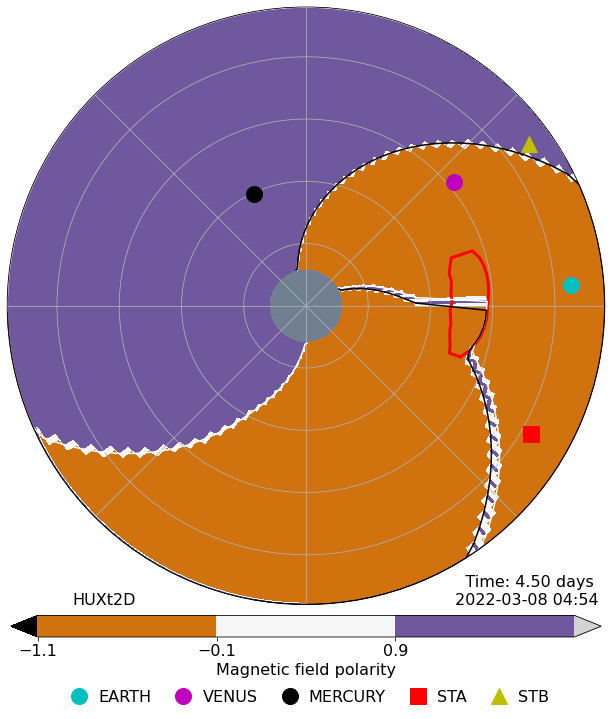

In [4]:
cr = 2254
vr_in = Hin.get_MAS_long_profile(cr, 0.0*u.deg)
model = H.HUXt(v_boundary=vr_in, cr_num=cr, cr_lon_init = 50*u.deg, simtime=5*u.day, dt_scale=1, frame='sidereal',  enable_field_tracer = True)
#add a CME and solve
cme = H.ConeCME(t_launch=2.5*u.day, longitude=0.0*u.deg, width=40*u.deg, v=1000*(u.km/u.s), thickness=5*u.solRad)
cme_list = [cme]
model.solve(cme_list)

#get the Br values from the HelioMAS solution
br_in = Hin.get_MAS_br_long_profile(model.cr_num, 0.0*u.deg)  

#compute the HCS streaklines and the b_grid
HA.add_bgrid(model, br_in)

#plot the speed solution, including the HCS
time = 4.5*u.day
HA.plot(model, time)

#plot the b-polarity grid
HA.plot_bpol(model, time)

## Example 18.
<a id="example_18"></a>
Extract and plot the timeseries at Earth

Files already exist for CR2054
Files already exist for CR2054


Files Downloaded: 100%|████████████████████████| 1/1 [00:00<00:00,  1.54file/s]


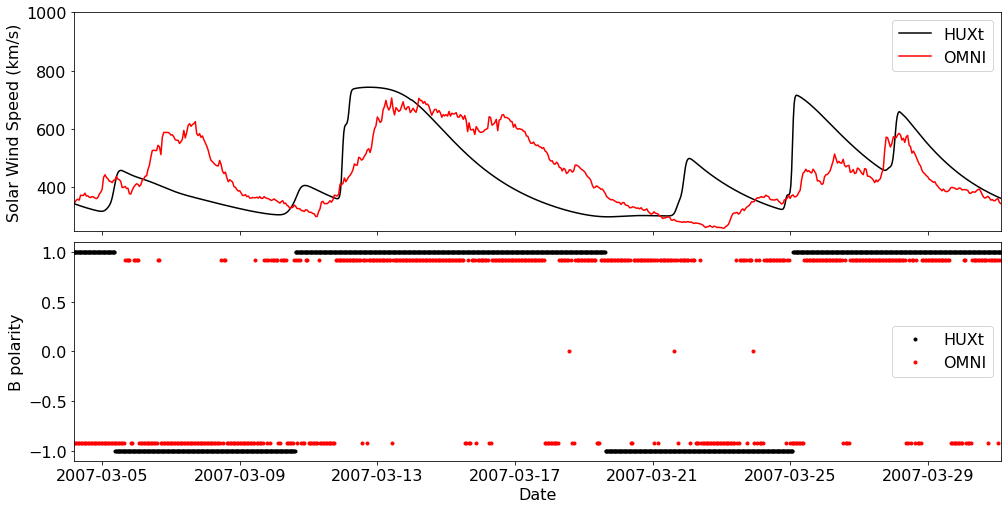

In [16]:
cr = 2054 # March, so Earth is around  - 7 degrees lat
lat = -7*u.deg

vr_in = Hin.get_MAS_long_profile(cr,lat)
#now run HUXt
model = H.HUXt(v_boundary=vr_in, cr_num=cr, latitude=lat, simtime=27*u.day, dt_scale=4, frame = 'sidereal', enable_field_tracer = True)
model.solve([]) 

#get the Br values from the HelioMAS solution
br_in = Hin.get_MAS_br_long_profile(model.cr_num, lat)  

#compute the HCS streaklines and the b_grid
HA.add_bgrid(model, br_in)

#the Earth time series can be plotted, along with OMNI data (downloaded on demand), using:
HA.plot_earth_timeseries(model, plot_omni = True)

#the Earth time series can be extracted as a DataFrame using:
earth_series = HA.get_earth_timeseries(model)


## Example 19.
<a id="example_19"></a>

There is some limited support for running HUXt in 3D. Currently this amounts to a wrapper class, `HUXt3D`, that computes the longitudinal solutions for a range of latitudes. At present it isn't possible to render the CME coordinates in zonal slices. 

Files already exist for CR2000


(<Figure size 720x720 with 2 Axes>, <PolarAxesSubplot:>)

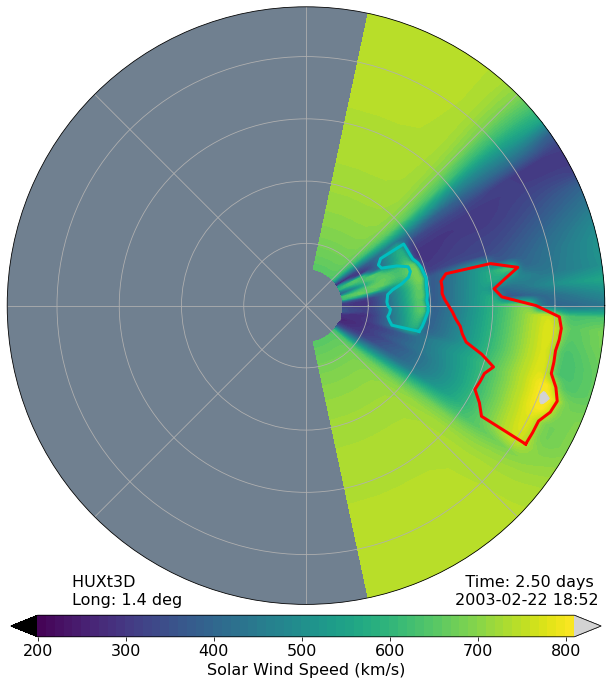

In [2]:
#set up a meridional cut run.
cr=2000
vmap, vlongs, vlats = Hin.get_MAS_vr_map(cr)

model3d=H.HUXt3d(cr_num=cr,v_map=vmap, v_map_lat=vlats, v_map_long=vlongs,
                    latitude_max=90*u.deg, latitude_min=-90*u.deg, lon_out=0.0*u.deg,
                    simtime=5*u.day, r_min=30*u.solRad)

#run the model with a couple of CMEs
cme1 = H.ConeCME(t_launch=0.5*u.day, longitude=0.0*u.deg, latitude=-10*u.deg,
                width=50*u.deg, v=800*(u.km/u.s), thickness=5*u.solRad)

cme2 = H.ConeCME(t_launch=1.5*u.day, longitude=0.0*u.deg, latitude=10*u.deg,
                width=50*u.deg, v=1000*(u.km/u.s), thickness=5*u.solRad)
cme_list=[]
cme_list.append(cme1)
cme_list.append(cme2)
model3d.solve(cme_list)

#produce a movie of r-lat cut at constant lon
HA.animate_3d(model3d, lon=0*u.deg, tag='model3d')

#plot r-lat cut at constant lon
HA.plot3d_radial_lat_slice(model3d, 2.5*u.day, lon=0*u.deg)

## Example 20.
<a id="example_20"></a>
HUXt can be run from 1-AU outwards using OMNI observations as the inner boundary condition. Functions exist for downloading and processing the OMNI data, as well as setting up the model run. The same functionality can also be used for time-dependent boundary conditions from coronal models.

Files Downloaded: 100%|████████████████████████| 2/2 [00:00<00:00,  4.06file/s]


Adjusting CME HEEQ longitude for sidereal frame


(<Figure size 720x720 with 2 Axes>, <PolarAxesSubplot:>)

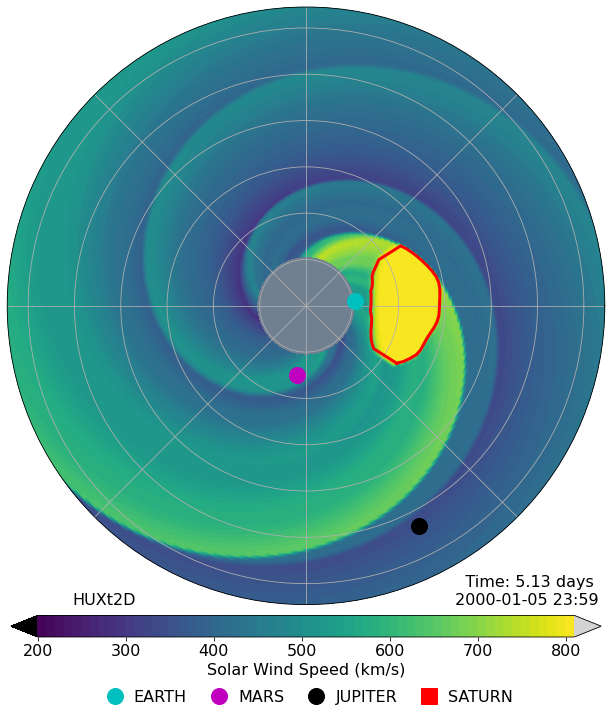

In [3]:
runstart = datetime.datetime(2000,1,1)
runend = datetime.datetime(2000,3,1)
simtime = (runend-runstart).days * u.day
r_min = 215 *u.solRad

#download and process the OMNI data
time, vcarr = Hin.generate_vCarr_from_OMNI(runstart, runend)

#set up the model
model = Hin.set_time_dependent_boundary(vcarr, time, runstart, simtime, 
                                        r_min=r_min, r_max=1290*u.solRad, dt_scale=50, latitude=0*u.deg)

#cme properties must be specified relative to the inner boundary (i.e. time at 1 AU and angles relative to Earth)
cme = H.ConeCME(t_launch=1.5*u.day, longitude=0.0*u.deg, latitude=0.0*u.deg,
                width=70*u.deg, v=800*(u.km/u.s), thickness=2*u.solRad, initial_height=r_min)

model.solve([cme]) #can take a couple of minutes to process the input data and solve the model out to Jupiter for 3 months

HA.plot(model, 5*u.day, save = 'True', tag = 'HUXt_OMNI_CME.pdf')